In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2
from natsort import natsorted
import os
import numpy as np

# 0. Data acquisition

In [16]:
save_path = r'./res'
images_path = r'./images'
annotations_path = r'./annotations'

# Get images name
images_list = natsorted(list(os.listdir(images_path)))

# Load images and grayscale images
images = []
images_grayscale = []
for image_name in images_list: 
    # Read images and save in a list
    image = cv2.imread(os.path.join(images_path, image_name))
    images.append(image)

    # Save also grayscale images
    image_grayscale = cv2.imread(os.path.join(images_path, image_name), 0)
    images_grayscale.append(image_grayscale)

# 1. Background removal
Since the images have been made using a static camera, we can perform a cropping of the areas where we do not plan to find people. These areas include the mountainous area, the boat area...

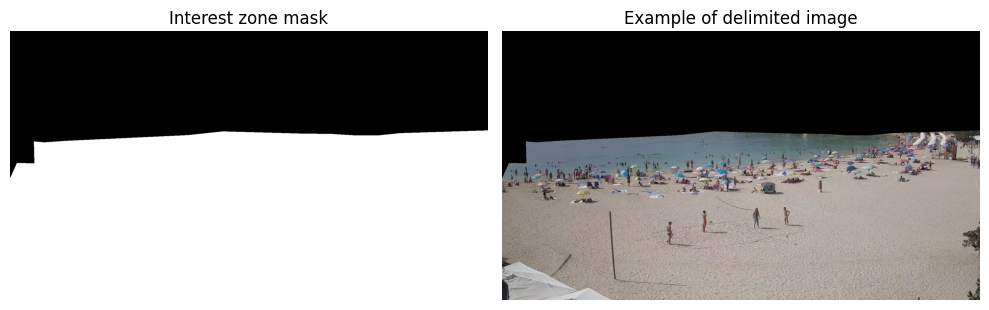

In [17]:
# Corner points that delimit the area of interest
bg_points = np.array([
    (0, 589),
    (27, 529),
    (97, 530),
    (95, 442),
    (137, 446),
    (223, 440),
    (714, 417),
    (854, 402),
    (1179, 411),
    (1288, 412),
    (1384, 418),
    (1480, 418),
    (1566, 409),
    (1920, 398),
    (1920, 0),
    (0, 0)
])

background_mask = np.zeros((1080, 1920), dtype=np.uint8)
cv2.fillPoly(background_mask, [bg_points], color=255)
background_mask = cv2.bitwise_not(background_mask)
cv2.imwrite(os.path.join(save_path, 'background.jpg'), background_mask)

for idx, image in enumerate(images_grayscale):
    images_grayscale[idx] = cv2.bitwise_and(image, image, mask=background_mask)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(background_mask, cmap='gray')
axs[0].set_title('Interest zone mask')
axs[0].axis('off')

cropped_image = cv2.bitwise_and(images[0], images[0], mask=background_mask)
axs[1].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
axs[1].set_title('Example of delimited image')
axs[1].axis('off')  # Turn off axes

plt.tight_layout()
plt.show()

# cv2.imshow('', images_grayscale[0])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

As we can see, by making this cut we keep the area of interest, the beach and the bathers' area, while reducing the areas that are not of interest to us and can contribute noise when counting the number of people.

# 2. Image averaging
The next step is to try to remove the static elements of the beach, which is mainly a single one: the sand. To do this, we will try to select the images with the (almost) empty beach, we will make use of a `GaussianBlurr` to smooth the images, followed by `image averaging` and then `image subtraction` to try to remove the sand.

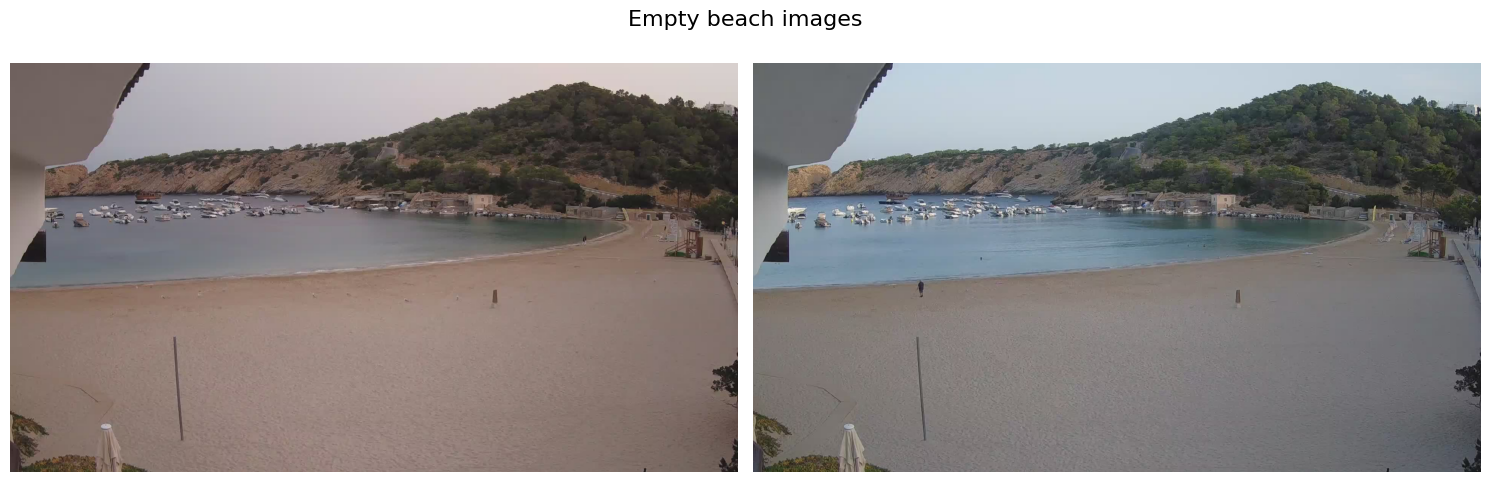

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Empty beach images', fontsize=16)

axs[0].imshow(cv2.cvtColor(images[-1], cv2.COLOR_BGR2RGB))
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(images[-2], cv2.COLOR_BGR2RGB))
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [19]:
bg_images = np.array([images_grayscale[-1]])

# fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# axs[0, 0].imshow(bg_images[0], cmap='gray')
# axs[0, 0].set_title('Non-blurred image')
# axs[0, 0].axis('off')

# axs[0, 1].imshow(bg_images[1], cmap='gray')
# axs[0, 1].set_title('Non-blurred image')
# axs[0, 1].axis('off')

for idx, img in enumerate(bg_images): 
    bg_images[idx] = cv2.GaussianBlur(img, ksize=(7,7), sigmaX=0)

# axs[1, 0].imshow(bg_images[0], cmap='gray')
# axs[1, 0].set_title('Blurred image')
# axs[1, 0].axis('off')

# axs[1, 1].imshow(bg_images[1], cmap='gray')
# axs[1, 1].set_title('Blurred image')
# axs[1, 1].axis('off')


# plt.tight_layout()
# plt.show()

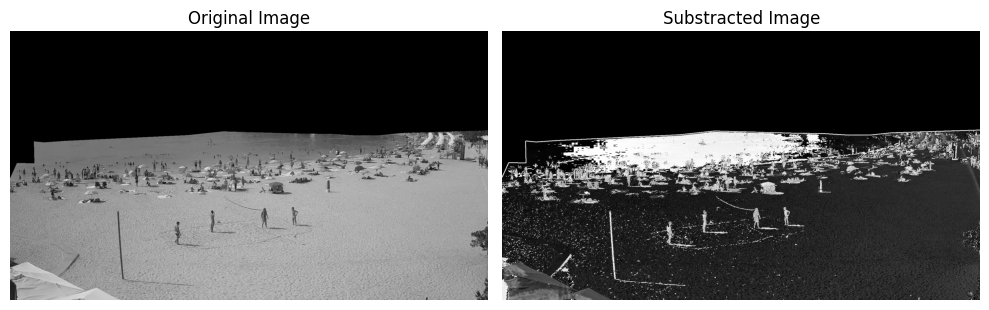

In [20]:
average_image = np.mean(bg_images, axis=0).astype(np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(images_grayscale[0], cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

# substraction = np.empty_like(images_grayscale)
for idx, img in enumerate(images_grayscale): 
    images_grayscale[idx] = img - average_image



axs[1].imshow(images_grayscale[0], cmap='gray')
axs[1].set_title('Substracted Image')
axs[1].axis('off')  # Turn off axes

plt.tight_layout()
plt.show()

As we can see, we can differentiate quite well the people on the sand, giving indications that applying some thresholding technique would allow us to completely eliminate the sand. However, we seem to have a problem with the sea as well.

# 3. Water and Sand removal

Fortunately, it seems that the silhouette of people is placed in a limited range that seems to exclude them from the environment (mainly water and sand), so we will try to find a range that allows us to make a proper division without losing people information. 

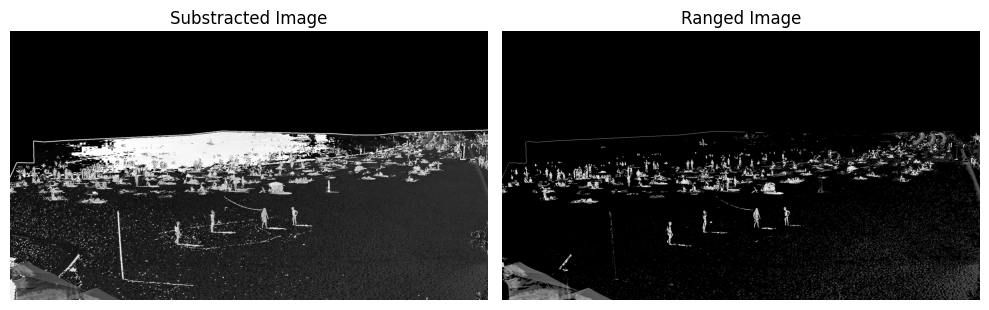

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(images_grayscale[0], cmap='gray')
axs[0].set_title('Substracted Image')
axs[0].axis('off')

lower_threshold = 50
upper_threshold = 220
for idx in range(len(images_grayscale)): 
    # img = cv2.GaussianBlur(images_grayscale[idx], ksize=(3,3), sigmaX=0)
    inrange_mask = cv2.inRange(images_grayscale[idx], lower_threshold, upper_threshold)
    img = cv2.bitwise_and(images_grayscale[idx], images_grayscale[idx], mask=inrange_mask)
    images_grayscale[idx] = img

axs[1].imshow(images_grayscale[0], cmap='gray')
axs[1].set_title('Ranged Image')
axs[1].axis('off')  # Turn off axes
plt.tight_layout()
plt.show()

Now that we have a fairly clean image, we will try to carry out the binarization, trying to lose as little information as possible, using the Otsu method.

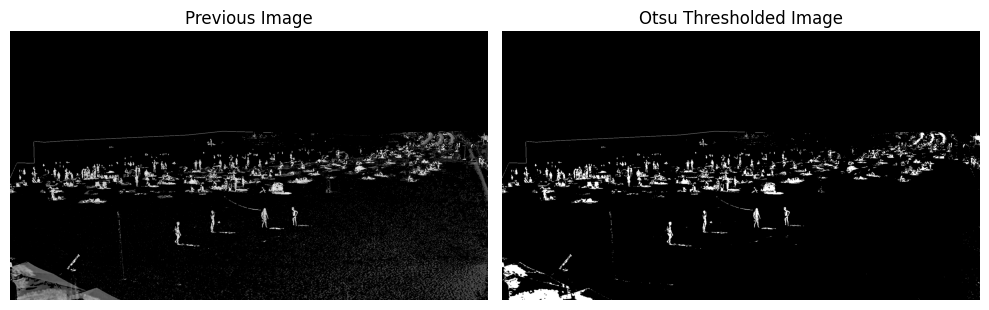

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(images_grayscale[0], cmap='gray')
axs[0].set_title('Previous Image')
axs[0].axis('off')

for idx in range(len(images_grayscale)):
    _, img = cv2.threshold(images_grayscale[idx], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    images_grayscale[idx] = img

axs[1].imshow(images_grayscale[0], cmap='gray')
axs[1].set_title('Otsu Thresholded Image')
axs[1].axis('off')  # Turn off axes

plt.tight_layout()
plt.show()

# 4. Skeletonization

I am not sure if it is really necessary to perform skeletonization or we can play with the full body mask

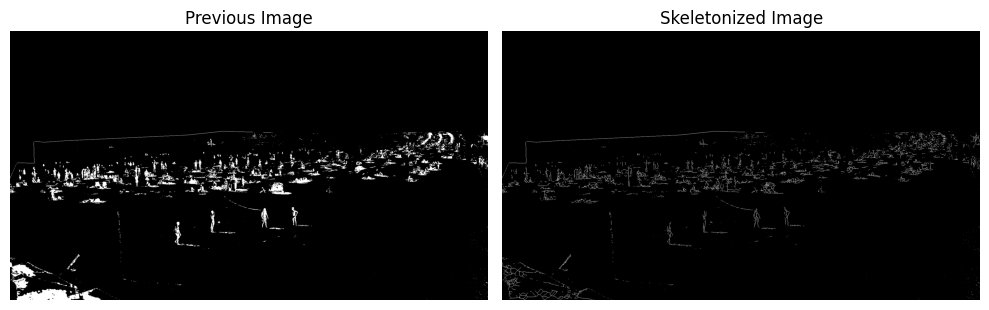

In [23]:
from skimage.morphology import skeletonize

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(images_grayscale[0], cmap='gray')
axs[0].set_title('Previous Image')
axs[0].axis('off')

for idx in range(len(images_grayscale)): 
    img = skeletonize(images_grayscale[idx])
    images_grayscale[idx] = img

axs[1].imshow(images_grayscale[0], cmap='gray')
axs[1].set_title('Skeletonized Image')
axs[1].axis('off')  # Turn off axes
plt.tight_layout()
plt.show()